In [47]:
import rslaser.rsoptics
from rslaser.rsoptics.element import *
import rslaser.rscavity
from rslaser.rscavity.laser_cavity import *

from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import time
from pykern.pkcollections import PKDict

In [19]:
k=PKDict()

#Define parameters for laser pulse starting at center of crystal
k.wavefrontEnergy = 1.55 #Wavefront Energy [eV]. 1.55 eV is 800 nm wavelength
k.lam = 1239.8*1e-9/k.wavefrontEnergy # convert energy [eV] to wavelength [m]
print('lam = %1.9f m' % k.lam)

k.sigrW =  0.000186 # rms size of laser pulse at waist

k.nslice=5
k.sig_s=0.1 #rms length of Gaussian laser pulse [m]

k.phE=k.wavefrontEnergy
k.energyChirp=.01

#create laser pulse
LP = LaserPulse(k)

lam = 0.000000800 m


In [44]:
slice=LP._slice
wfr0=slice[0]._wfr

Size of initial wavefront data array (coordinate): (1170, 1170)


/home/vagrant/.pyenv/versions/3.7.2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


NameError: name 'hfontLarge' is not defined

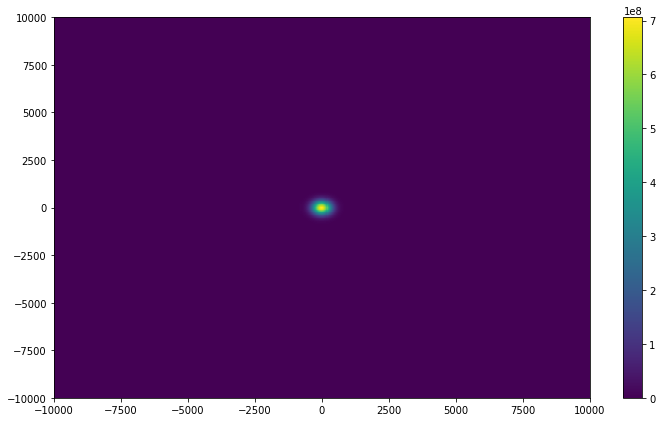

In [48]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis)  ##By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.colorbar()
#['Horizontal Position [mm]', , 'Intensity']
ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)
plt.show()

In [ ]:
wfr0=createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my) #creates Gaussian wavefront in SRW

In [ ]:
def createGsnSrcSRW(self, slice_index, nslice, d_to_w, sigrW=0.000436984, propLen=15, sig_s=0.1,
                 pulseE=0.001, poltype=1, phE=1.55, sampFact=5, mx=0, my=0, **_ignore_kwargs):
        """
        #nslice: number of slices of laser pulse
        #slice_index: index of slice
        #d_to_w: distance from the pulse center at t = 0 to the intended waist location [m]
        #sigrW: beam size at waist [m]
        #propLen: propagation length [m] required by SRW to create numerical Gaussian
        #propLen=15,
        #sig_s RMS pulse length [m]
        #pulseE: energy per pulse [J]
        #poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
        #phE: photon energy [eV]
        #sampFact: sampling factor to increase mesh density
        """
        #print([sigrW,propLen,pulseE,poltype])
        self.slice_index = slice_index
        self.phE = phE
        constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
        rmsAngDiv = constConvRad/(phE*sigrW)             ##RMS angular divergence [rad]
        #  if at t=0 distance to the waist location d_to_w < d_to_w_cutoff, initialization in SRW involves/requires propagation 
        #  from the distance-to-waist > d_to_w_cutoff to the actual z(t=0) for which d_to_w < d_to_w_cutoff 
        d_to_w_cutoff = 0.001  # [m] - verify that this is a reasonable value 
        if d_to_w > d_to_w_cutoff:  propLen = d_to_w  #  d_to_w = L_d1 +0.5*L_c in the single-pass example 
        sigrL=math.sqrt(sigrW**2+(propLen*rmsAngDiv)**2)  ##required RMS size to produce requested RMS beam size after propagation by propLen


        #***********Gaussian Beam Source
        GsnBm = srwlib.SRWLGsnBm() #Gaussian Beam structure (just parameters)
        GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
        GsnBm.y = 0
        numsig = 3. #Number of sigma values to track. Total range is 2*numsig*sig_s
        ds = 2*numsig*sig_s/(nslice - 1)
        self._pulse_pos = -numsig*sig_s+slice_index*ds
        GsnBm.z = propLen + self._pulse_pos #Longitudinal Position of Waist [m]
        GsnBm.xp = 0 #Average Angles of Gaussian Beam at Waist [rad]
        GsnBm.yp = 0
        GsnBm.avgPhotEn = phE #Photon Energy [eV]
        GsnBm.pulseEn = pulseE*np.exp(-self._pulse_pos**2/(2*sig_s**2)) #Energy per Pulse [J] - to be corrected
        GsnBm.repRate = 1 #Rep. Rate [Hz] - to be corrected
        GsnBm.polar = poltype #1- linear horizontal?
        GsnBm.sigX = sigrW #Horiz. RMS size at Waist [m]
        GsnBm.sigY = GsnBm.sigX #Vert. RMS size at Waist [m]

        GsnBm.sigT = 10e-15 #Pulse duration [s] (not used?)
        GsnBm.mx = mx #Transverse Gauss-Hermite Mode Orders
        GsnBm.my = my

        #***********Initial Wavefront
        wfr = srwlib.SRWLWfr() #Initial Electric Field Wavefront
        wfr.allocate(1, 1000, 1000) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
        wfr.mesh.zStart = 0.0 #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
        wfr.mesh.eStart = GsnBm.avgPhotEn #Initial Photon Energy [eV]
        wfr.mesh.eFin = GsnBm.avgPhotEn #Final Photon Energy [eV]

        wfr.unitElFld = 1 #Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

        distSrc = wfr.mesh.zStart - GsnBm.z
        #Horizontal and Vertical Position Range for the Initial Wavefront calculation
        #can be used to simulate the First Aperture (of M1)
        #firstHorAp = 8.*rmsAngDiv*distSrc #[m]
        xAp = 8.*sigrL
        yAp = xAp #[m]

        wfr.mesh.xStart = -0.5*xAp #Initial Horizontal Position [m]
        wfr.mesh.xFin = 0.5*xAp #Final Horizontal Position [m]
        wfr.mesh.yStart = -0.5*yAp #Initial Vertical Position [m]
        wfr.mesh.yFin = 0.5*yAp #Final Vertical Position [m]

        sampFactNxNyForProp = sampFact #sampling factor for adjusting nx, ny (effective if > 0)
        arPrecPar = [sampFactNxNyForProp]

        srwlib.srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)

        ##Beamline to propagate to waist ( only if d_to_w(t=0) < d_to_w_cutoff )
        if d_to_w < d_to_w_cutoff: 
          optDriftW=srwlib.SRWLOptD(propLen)
          propagParDrift = [0, 0, 1., 0, 0, 1.1, 1.2, 1.1, 1.2, 0, 0, 0]
          optBLW = srwlib.SRWLOptC([optDriftW],[propagParDrift])
          #wfrW=deepcopy(wfr)
          srwlib.srwl.PropagElecField(wfr, optBLW)
        self._wfr = wfr
